# Coronavirus articles

En esta notebook mostraremos algunos 

In [1]:
%load_ext autoreload
%autoreload 2
from mongoengine import connect
from tweepyrate import create_apps
from hatespeech_models import Tweet, Article

client = connect("hatespeech-news")


print(f"Tenemos {Article.objects.count()} artículos")

Tenemos 86606 artículos


Busquemos artículos con:

* 10 comentarios al menos
* Con al menos un comentario marcado como odioso
* Que hable de Coronavirus

In [2]:
initial_query = {
    "comments__10__exists": True,
    #"comments__hateful_value__gt": 0.5
}
articles = Article.objects(**initial_query).search_text('chinos')
print(articles.count())

1693


Contemos comentarios con odio

Salvo primero todo esto!

In [3]:
articles = list(articles)

In [4]:
from tqdm.auto import tqdm
import numpy as np
threshold = 0.5

for article in tqdm(articles):
    values = np.array([com.hateful_value for com in article.comments])
    article.hateful_comments_count = sum(values > threshold)
    article.mean_value = values.mean()
    

Vamos a quedarnos sólo con aquellos que tienen más de dos comentarios odiosos


Text(0, 0.5, 'Cantidad de comentarios')

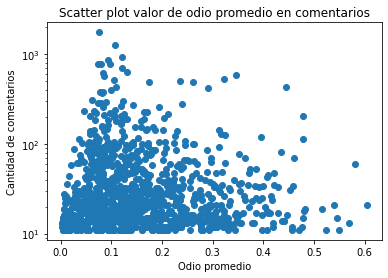

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter([art.mean_value for art in articles], [len(art.comments) for art in articles]);

plt.semilogy()
plt.title("Scatter plot valor de odio promedio en comentarios")
plt.xlabel("Odio promedio")
plt.ylabel("Cantidad de comentarios")

In [6]:
hateful_articles = [art for art in articles if art.mean_value > 0.3]

print(f"Hay {len(hateful_articles)} artículos")

Hay 127 artículos


In [7]:
from termcolor import cprint

def display_article(article):
    print("Artículo:", end="")
    print(article)
        
    for comment in article.comments: 
        print(f"{comment.hateful_value:.2f} --", end = "")
        attrs = []
        
        if comment.hateful_value > threshold:
            attrs.append("bold")
        cprint(f"{comment.text}", attrs=attrs)



In [ ]:

for art in hateful_articles:
    display_article(art)
    print(("="*80 + '\n')*5)

In [22]:
import json
from datetime import datetime



articles = Article.objects(**initial_query).search_text('chinos')
articles = articles.fields(_id=0)

def serialize(art):
    ret = art.to_mongo().to_dict()
    ret["created_at"] = datetime.strftime(ret["created_at"], "%d-%b-%Y (%H:%M:%S)")
    return ret

articles = [serialize(a) for a in articles]

path = "../dumps/articulos_chinos.json"
with open(path, "w+") as f:
    json.dump(articles, f)

## Chequear un poco estos datos

In [23]:
import json

with open(path) as f:
    articles = json.load(f)

In [24]:
from tqdm.auto import tqdm
import numpy as np
threshold = 0.5

for article in tqdm(articles):
    values = np.array([com["hateful_value"] for com in article["comments"]])
    article["hateful_comments_count"] = sum(values > threshold)
    article["mean_value"] = values.mean()
    

Veamos la distribución de cantidad de comentarios 'odiosos' por artículo

Text(0.5, 1.0, "Histograma de cantidad de comentarios posiblemente 'odiosos' por artículo")

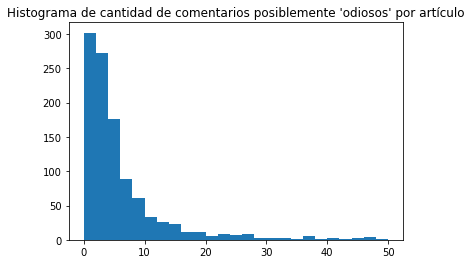

In [25]:
plt.hist([art["hateful_comments_count"] for art in articles], bins=25, range=[0, 50]);
plt.title("Histograma de cantidad de comentarios posiblemente 'odiosos' por artículo")

Calculé otra métrica (que posiblemente no tenga mucho sentido): el valor de odio promedio por comentario para cada cartículo. Veamos cómo se distribuye

Text(0.5, 1.0, "Histograma de valor medio de 'odio' por comentario de cada artículo")

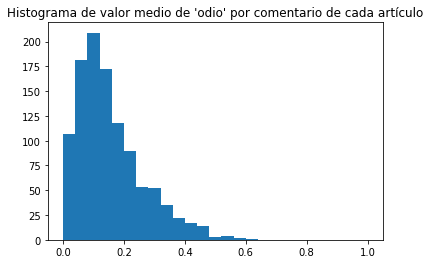

In [26]:
plt.hist([art["mean_value"] for art in articles], bins=25, range=[0, 1]);
plt.title("Histograma de valor medio de 'odio' por comentario de cada artículo")

Me quedo sólo con los que tengan tres o más comentarios con odio

In [27]:
hateful_articles = [art for art in articles if art["mean_value"] >= 0.35]

print(f"Ahora me quedo con {len(hateful_articles)}")

Ahora me quedo con 70


In [28]:
from termcolor import cprint
from datetime import datetime

def display_article(article):
    print(("="*80 + '\n')*4)
    print(f"Tweet id: {article['tweet_id']}")
    date = (article["created_at"])
    print(f"{article['user']}: {date}\n")
    print(article['text'])
        
    print("\nComentarios\n")
    for i, comment in enumerate(article['comments']): 
        print(f"{i+1:<3} | {comment['hateful_value']:.2f} --", end = "")
        attrs = []
        
        if comment['hateful_value'] > threshold:
            attrs.append("bold")
        cprint(f"{comment['text']}", attrs=attrs)



In [29]:
for art in hateful_articles:
    display_article(art)


Tweet id: 1244637752962027520
elpaisuy: 30-Mar-2020 (14:48:59)

Inmigrantes en Uruguay: 180 pedidos de techo y comida por día al Mides  https://t.co/V1TWnzSAGA

Comentarios

1   | 0.00 --@elpaisuy Otro clavo que dejo el fraude amplio!!!
2   | 0.01 --@elpaisuy Quizás deberían buscar otros horizontes, nosotros no los podemos ayudar más
3   | 0.00 --@elpaisuy Recomiendo ver el discurso de ayer de Alberto Fernandez @alferdez. Es un juego de cuarentena...Busque las mil diferencias morales con el gobierno Uruguayo.
https://t.co/Rw4FsG95FL
4   | 0.01 --@elpaisuy Los xenófobos saliendo de la cueva https://t.co/LJuNEb9ply
5   | 0.96 --@elpaisuy Me parecería muy injusto que le den vivienda a ellos y no a los Uruguayos. Muchos estamos peleando por una casa.
6   | 0.01 --@elpaisuy Vayan a las respectivas embajadas, ahí les van a dar, no jodan, vayan a la casa del Pepe , no era que se iva a hacer cargo
7   | 0.00 --@elpaisuy Avion y para su pais . ✋
8   | 1.00 --@elpaisuy No me extraña, estoy tapi